In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
from tensorflow.keras import models, layers, backend
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from skimage.metrics import structural_similarity

In [2]:
imsize = (100,100)

thresh = 50

In [3]:
##
## Importing the "Yes" pictures
##
## The loop will find the middle array of pixels for the length and width
## and then find the min and max index that meets a threshold. It then
## crops the image to remove a majority of the black space in the images.
##

Yes = []

for i in os.listdir('Brain_Tumor_Detection/yes/'):
    file = 'Brain_Tumor_Detection/yes/' + i
    img = np.array(Image.open(file).convert('L'))
    s1,s2 = img.shape
    hmin = np.min(np.argwhere(img[s1//2,:] > thresh))
    hmax = np.max(np.argwhere(img[s1//2,:] > thresh))
    vmin = np.min(np.argwhere(img[:,s2//2-5] > thresh))
    vmax = np.max(np.argwhere(img[:,s2//2-5] > thresh))
    img = img[vmin:vmax,hmin:hmax]
    img = Image.fromarray(img).resize(imsize)
    img = np.array(img)
    Yes.append(img)

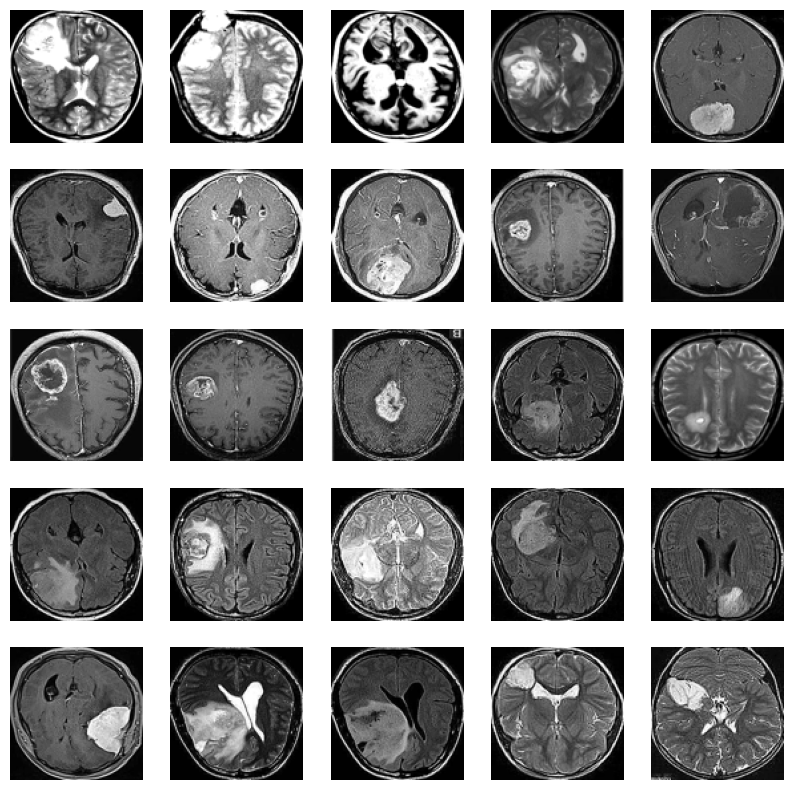

In [4]:
fig, ax = plt.subplots(5,5, figsize=(10,10))
for r in range(5):
    for c in range(5):
        ax[r,c].imshow(Yes[r*5+c], cmap='gray')
        ax[r,c].axis('off')
plt.show()

In [5]:
##
## Importing the "No" pictures
##
## The loop will find the middle array of pixels for the length and width
## and then find the min and max index that meets a threshold. It then
## crops the image to remove a majority of the black space in the images.
##

No = []

for i in os.listdir('Brain_Tumor_Detection/no/'):
    file = 'Brain_Tumor_Detection/no/' + i
    img = np.array(Image.open(file).convert('L'))
    s1,s2 = img.shape
    hmin = np.min(np.argwhere(img[s1//2,:] > thresh))
    hmax = np.max(np.argwhere(img[s1//2,:] > thresh))
    vmin = np.min(np.argwhere(img[:,s2//2-5] > thresh))
    vmax = np.max(np.argwhere(img[:,s2//2-5] > thresh))
    img = img[vmin:vmax,hmin:hmax]
    img = Image.fromarray(img).resize((imsize))
    img = np.array(img)
    No.append(img)

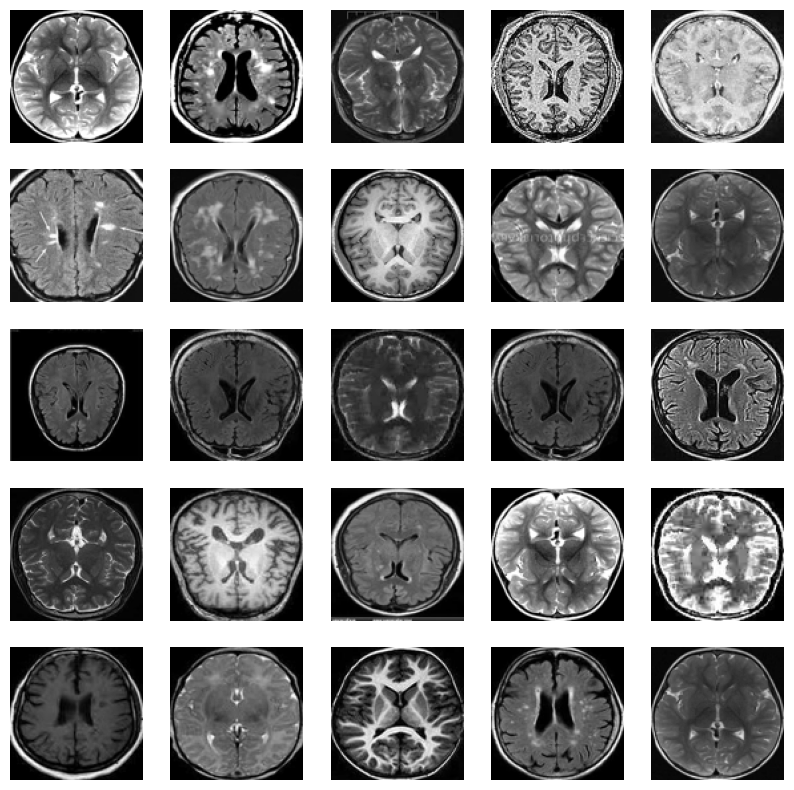

In [6]:
fig, ax = plt.subplots(5,5, figsize=(10,10))
for r in range(5):
    for c in range(5):
        ax[r,c].imshow(No[r*5+c], cmap='gray')
        ax[r,c].axis('off')
plt.show()

In [7]:
## Creating a combined X data set and normalizing the data

No = np.array(No)
Yes = np.array(Yes)

xdata = np.concatenate([No, Yes], axis=0)
xdata = xdata / 255

xdata.shape

(2966, 100, 100)

In [8]:
## One-hot encoding and combining the Y label data set

yNo = np.zeros(No.shape[0])
yYes = np.ones(Yes.shape[0])

ydata = np.concatenate([yNo, yYes])
ydata = ydata.reshape(ydata.shape[0],1)
#ydata = np.concatenate([ydata, -ydata+1], axis=1)
ydata.shape

(2966, 1)

In [9]:
## Splitting the data into training and testing sets

xtrain, xtest, ytrain, ytest = train_test_split(xdata, ydata, test_size=0.20, random_state=0)

In [10]:
## Splitting the data into training and testing sets

XVtrain, XVtest, YVtrain, YVtest = train_test_split(xtrain, ytrain, test_size=0.20, random_state=0)

In [105]:
## Creating a Convolutional Neural Network

backend.clear_session()

cnn = models.Sequential()
cnn.add(layers.InputLayer(input_shape=(imsize[0],imsize[1],1)))

cnn.add(layers.Conv2D(filters=16, kernel_size=5, strides=1))
cnn.add(layers.LeakyReLU(alpha=0.2))

cnn.add(layers.Conv2D(filters=32, kernel_size=5, strides=2))
cnn.add(layers.LeakyReLU(alpha=0.2))
cnn.add(layers.Dropout(0.2))

cnn.add(layers.Flatten())

cnn.add(layers.Dense(16))
cnn.add(layers.LeakyReLU(alpha=0.2))

cnn.add(layers.BatchNormalization())
cnn.add(layers.Dense(1, activation='sigmoid'))

cnn.compile(optimizer='adam', metrics='accuracy', loss='binary_crossentropy')

cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 96, 96, 16)        416       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 96, 96, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 46, 46, 32)        12832     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 46, 46, 32)        0         
                                                                 
 dropout (Dropout)           (None, 46, 46, 32)        0         
                                                                 
 flatten (Flatten)           (None, 67712)             0         
                                                                 
 dense (Dense)               (None, 16)                1

In [106]:
## Training the model on the training data

cnn.fit(XVtrain.reshape(XVtrain.shape[0], XVtrain.shape[1], XVtrain.shape[2], 1), YVtrain,
        validation_data=(XVtest.reshape(XVtest.shape[0], XVtest.shape[1], XVtest.shape[2], 1), YVtest),
        epochs = 5)

Epoch 1/5
60/60 [==============================] - 10s 152ms/step - loss: 0.4915 - accuracy: 0.7686 - val_loss: 0.3837 - val_accuracy: 0.8968
Epoch 2/5
60/60 [==============================] - 8s 140ms/step - loss: 0.2097 - accuracy: 0.9251 - val_loss: 0.2813 - val_accuracy: 0.9137
Epoch 3/5
60/60 [==============================] - 9s 144ms/step - loss: 0.1055 - accuracy: 0.9673 - val_loss: 0.3502 - val_accuracy: 0.8379
Epoch 4/5
60/60 [==============================] - 9s 147ms/step - loss: 0.0431 - accuracy: 0.9926 - val_loss: 0.1485 - val_accuracy: 0.9705
Epoch 5/5
60/60 [==============================] - 9s 147ms/step - loss: 0.0283 - accuracy: 0.9963 - val_loss: 0.1114 - val_accuracy: 0.9726


In [107]:
## Predicting the labels for the validation and testing data

val_pred = cnn.predict(XVtest.reshape(XVtest.shape[0], XVtest.shape[1], XVtest.shape[2], 1), verbose=False)
test_pred = cnn.predict(xtest.reshape(xtest.shape[0], xtest.shape[1], xtest.shape[2], 1), verbose=False)

val_pred_labels = np.round(val_pred, 0)
test_pred_labels = np.round(test_pred, 0)

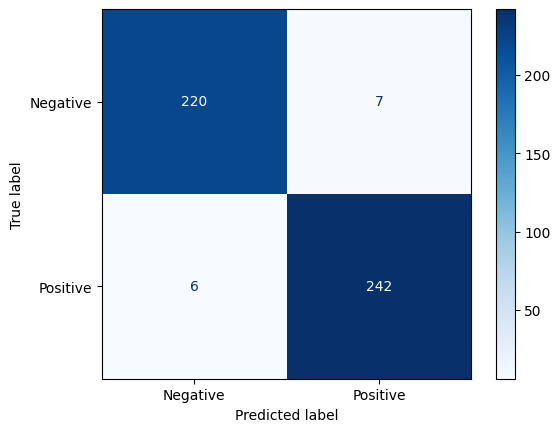

In [176]:
## Confusion matrix for the validation data

cnn_CM = confusion_matrix(YVtest, val_pred_labels)

ConfusionMatrixDisplay(cnn_CM, display_labels=['Negative', 'Positive']).plot(cmap='Blues')
plt.show()

In [177]:
def F1(CM):
    f1 = (2 * CM[1,1]) / (2 * CM[1,1] + CM[0,1] + CM[1,0])
    return f1

In [180]:
print("F1 score for CNN validation: {}".format(F1(cnn_CM)))

F1 score for CNN validation: 0.9738430583501007


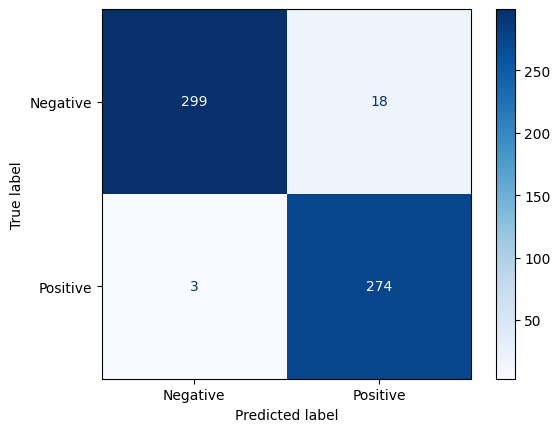

In [179]:
##
## Confusion matrix for the testing data
##
## In medical imaging, false negatives are more costly than false positives, so a lower FN rate is beneficial
##
cnn_CM2 = confusion_matrix(ytest, test_pred_labels)

ConfusionMatrixDisplay(cnn_CM2, display_labels=['Negative', 'Positive']).plot(cmap='Blues')
plt.show()

In [181]:
print("F1 score for CNN test: {}".format(F1(cnn_CM2)))

F1 score for CNN test: 0.9630931458699473


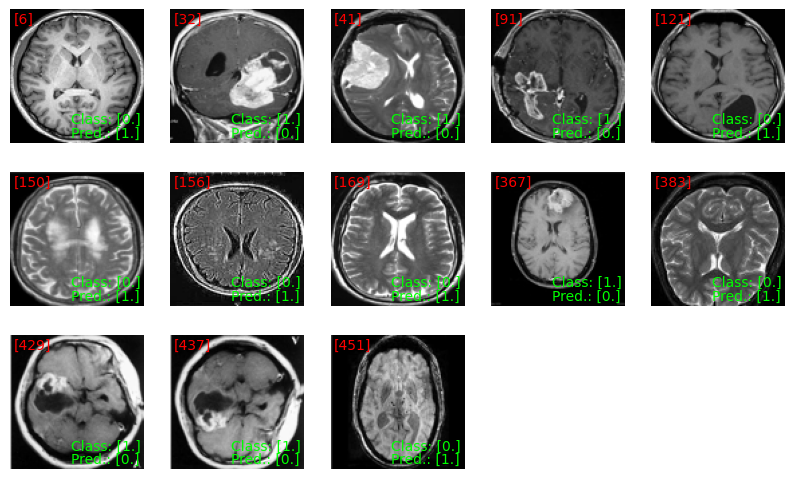

In [112]:
## Visualizing the misclassified validation data

Vmisclass = np.argwhere(val_pred_labels[:,0] != YVtest[:,0])

fig, ax = plt.subplots(3,5, figsize=(10,6))

for r in range(3):
    for c in range(5):
        i = r*5+c
        if i == 13:
            ax[r,c].axis('off')
            ax[r,c+1].axis('off')
            break
        
        ax[r,c].imshow(XVtest[Vmisclass[i,0]].reshape(100,100), cmap='gray')
        ax[r,c].text(x=2, y=10, s=Vmisclass[i], color='red')
        ax[r,c].text(x=45, y=85, s='Class: {}'.format(YVtest[Vmisclass[i,0]]), color=(0,1,0))
        ax[r,c].text(x=45, y=95, s='Pred.: {}'.format(val_pred_labels[Vmisclass[i,0]]), color=(0,1,0))
        ax[r,c].axis('off')

plt.show()

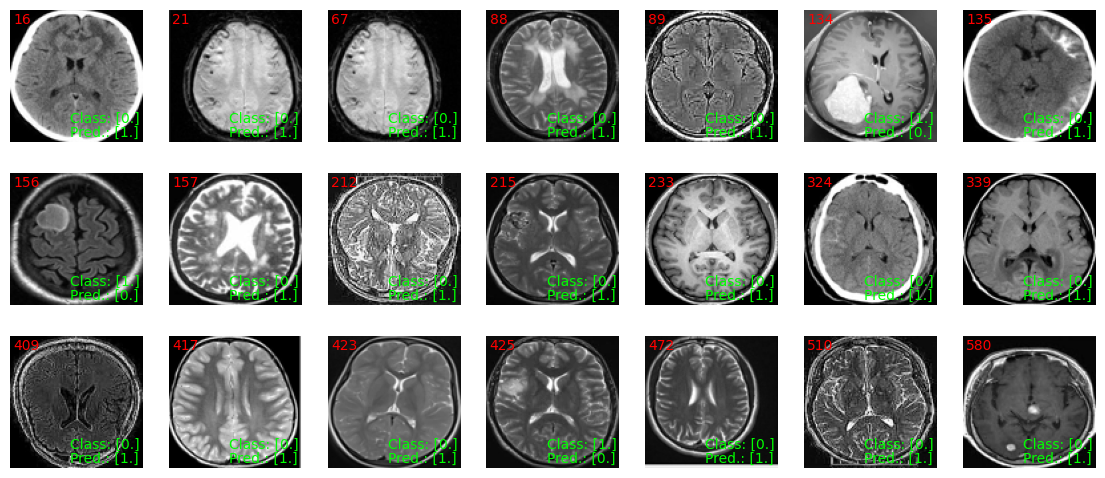

In [113]:
## Visualizing the misclassified testing data

misclass = np.argwhere(test_pred_labels[:,0] != ytest[:,0])

fig, ax = plt.subplots(3,7, figsize=(14,6))

for r in range(3):
    for c in range(7):
        i = r*7+c
        
        ax[r,c].imshow(xtest[misclass[i,0]].reshape(100,100), cmap='gray')
        ax[r,c].text(x=2, y=10, s=misclass[i,0], color='red')
        ax[r,c].text(x=45, y=85, s='Class: {}'.format(ytest[misclass[i,0]]), color=(0,1,0))
        ax[r,c].text(x=45, y=95, s='Pred.: {}'.format(test_pred_labels[misclass[i,0]]), color=(0,1,0))
        ax[r,c].axis('off')

plt.show()

In [114]:
## Importing the prediction data from the dataset

pred = []

for i in os.listdir('Brain_Tumor_Detection/pred/'):
    file = 'Brain_Tumor_Detection/pred/' + i
    img = np.array(Image.open(file).convert('L'))
    s1,s2 = img.shape
    hmin = np.min(np.argwhere(img[s1//2,:] > 50))
    hmax = np.max(np.argwhere(img[s1//2,:] > 50))
    vmin = np.min(np.argwhere(img[:,s2//2] > 50))
    vmax = np.max(np.argwhere(img[:,s2//2] > 50))
    img = img[vmin:vmax,hmin:hmax]
    img = Image.fromarray(img).resize(imsize)
    img = np.array(img)
    pred.append(img)

pred = np.array(pred)/255

In [123]:
fcnn = models.Sequential()
fcnn.add(layers.InputLayer(input_shape=(imsize[0],imsize[1],1)))

fcnn.add(layers.Conv2D(filters=16, kernel_size=5, strides=1))
fcnn.add(layers.LeakyReLU(alpha=0.2))

fcnn.add(layers.Conv2D(filters=32, kernel_size=5, strides=2))
fcnn.add(layers.LeakyReLU(alpha=0.2))
fcnn.add(layers.Dropout(0.2))

fcnn.add(layers.Flatten())

fcnn.add(layers.Dense(16))
fcnn.add(layers.LeakyReLU(alpha=0.2))

fcnn.add(layers.BatchNormalization())
fcnn.add(layers.Dense(1, activation='sigmoid'))

fcnn.compile(optimizer='adam', metrics='accuracy', loss='binary_crossentropy')

fcnn.fit(xdata, ydata, epochs=5)

Epoch 1/5
93/93 [==============================] - 13s 132ms/step - loss: 0.5077 - accuracy: 0.7755
Epoch 2/5
93/93 [==============================] - 12s 129ms/step - loss: 0.1507 - accuracy: 0.9434
Epoch 3/5
93/93 [==============================] - 12s 131ms/step - loss: 0.0782 - accuracy: 0.9788
Epoch 4/5
93/93 [==============================] - 12s 134ms/step - loss: 0.0374 - accuracy: 0.9922
Epoch 5/5
93/93 [==============================] - 12s 133ms/step - loss: 0.0205 - accuracy: 0.9980


In [126]:
## Predicing the labels for the new data

cnn_pred = fcnn.predict(pred.reshape(pred.shape[0],imsize[0],imsize[1],1), verbose=False)

In [127]:
pred_labels = np.round(cnn_pred, 0)
pred_labels.flatten()

array([0., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1.,
       1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
       1., 1., 0., 0., 0., 1., 1., 1., 1.], dtype=float32)

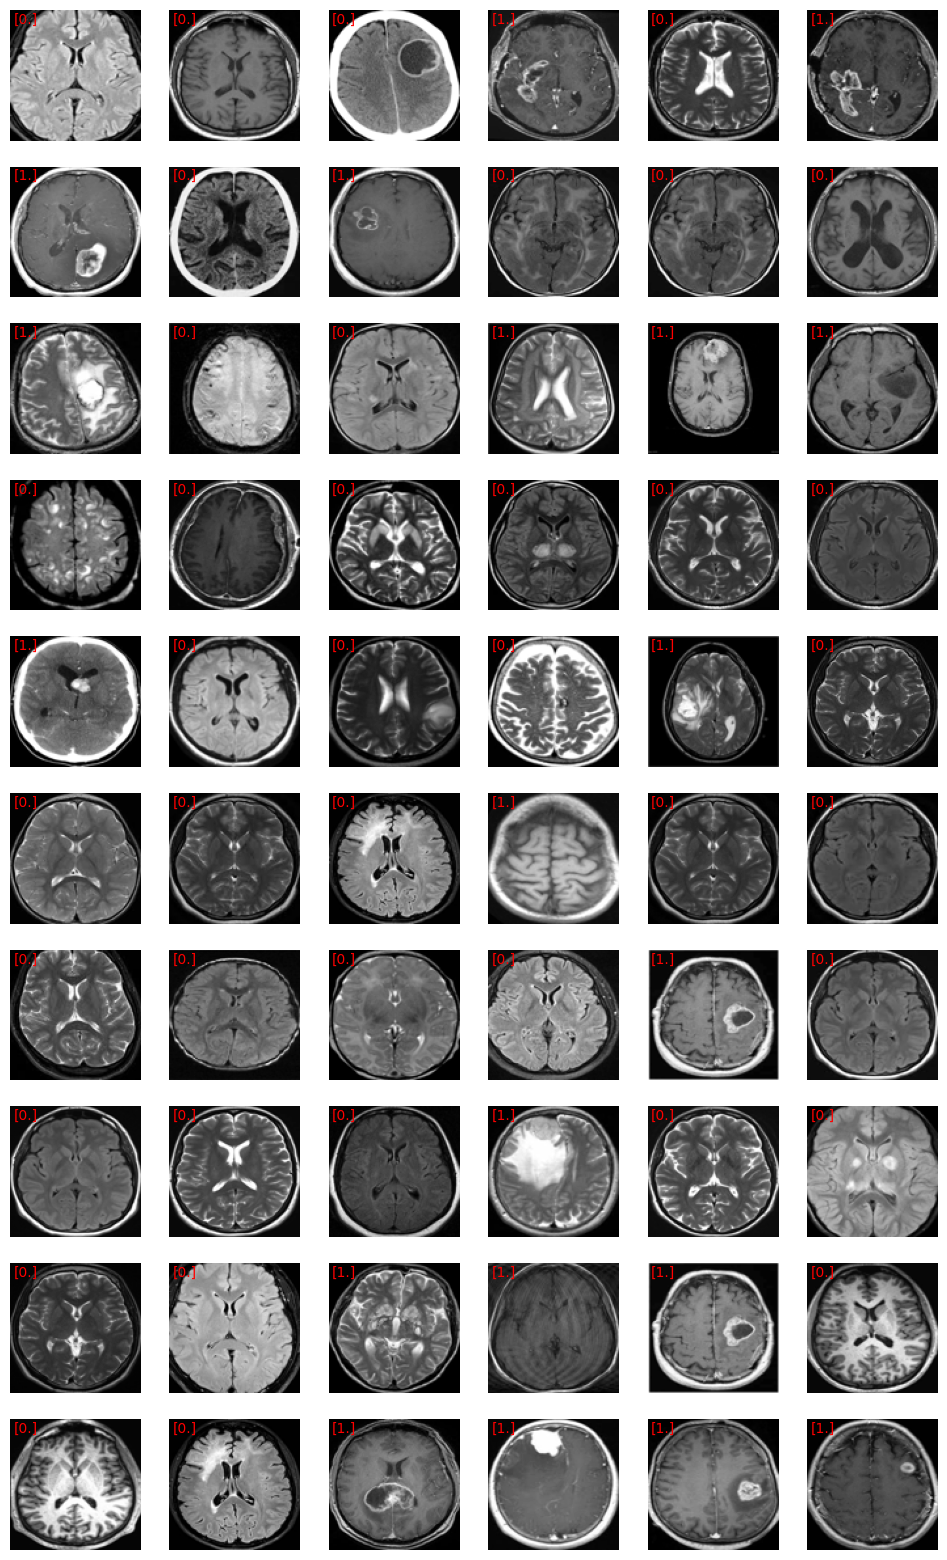

In [130]:
##
## Visualizing the prediction images with their predicted labels
##
## The CNN does a good job in detecting obvious tumors in the brain scans, but gives some apparent false positives as well.
##

fig, ax = plt.subplots(10,6, figsize=(12,20))
for r in range(10):
    for c in range(6):
        i = r*6+c
        ax[r,c].imshow(pred[i], cmap='gray')
        ax[r,c].text(x=2,y=10, s=pred_labels[i], color='red')
        ax[r,c].axis('off')
plt.show()

In [42]:
##
## We will now compare this method to a much more simple, though computationally heavy, structural similarity index.
##

ssim = [[structural_similarity(xtest[s], xtrain[r]) for r in range(len(xtrain))] for s in range(len(xtest))]

In [43]:
ssim = np.array(ssim)
ssim.shape

(594, 2372)

In [44]:
##
## Converting the SSIMs to labels by assigning the label of the closest match to the test data
##

best_match = np.argmax(ssim, axis=1)
best_label = ytrain[best_match]


##
## Calculating the testing error
##

np.mean(best_label == ytest)

0.9781144781144782

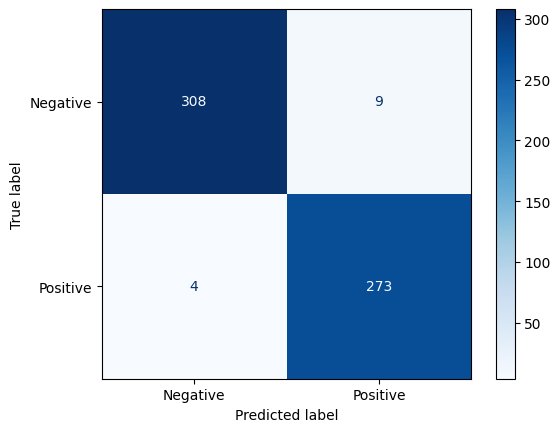

In [182]:
##
## Plotting the confusion matrix for the testing data
##
ssim_CM = confusion_matrix(ytest, best_label)

ConfusionMatrixDisplay(ssim_CM, display_labels=['Negative', 'Positive']).plot(cmap='Blues')
plt.show()

In [183]:
print("F1 score for SSIM test: {}".format(F1(ssim_CM)))

F1 score for SSIM test: 0.9767441860465116


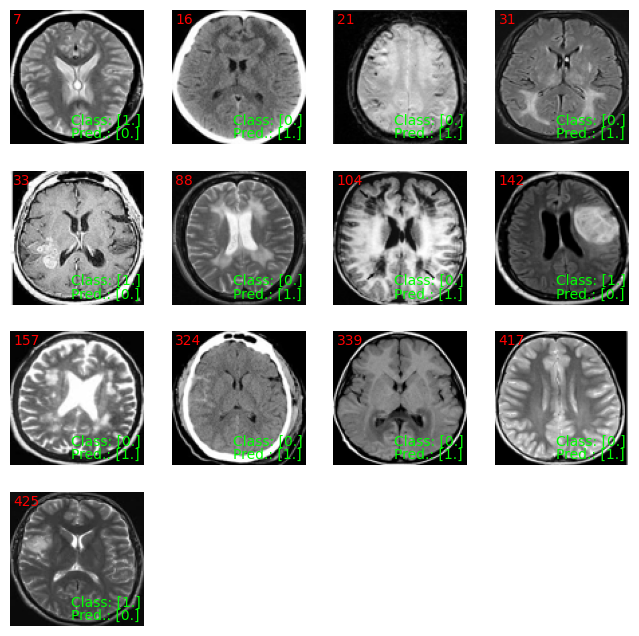

In [122]:
## Visualizing the misclassified testing data

Smisclass = np.argwhere(best_label != ytest)[:,0]

fig, ax = plt.subplots(4,4, figsize=(8,8))

for r in range(4):
    for c in range(4):
        i = r*4+c
        if i == 13:
            ax[r,c].axis('off')
            ax[r,c+1].axis('off')
            ax[r,c+2].axis('off')
            break
        
        ax[r,c].imshow(xtest[Smisclass[i]].reshape(100,100), cmap='gray')
        ax[r,c].text(x=2, y=10, s=Smisclass[i], color='red')
        ax[r,c].text(x=45, y=85, s='Class: {}'.format(ytest[Smisclass[i]]), color=(0,1,0))
        ax[r,c].text(x=45, y=95, s='Pred.: {}'.format(best_label[Smisclass[i]]), color=(0,1,0))
        ax[r,c].axis('off')

plt.show()

In [131]:
##
## Computing the labels of the prediction dataset
##

p_ssim = [[structural_similarity(pred[s], xdata[r]) for r in range(len(xdata))] for s in range(len(pred))]

In [133]:
p_ssim = np.array(p_ssim)
p_match = np.argmax(p_ssim, axis=1)
p_label = ydata[p_match]

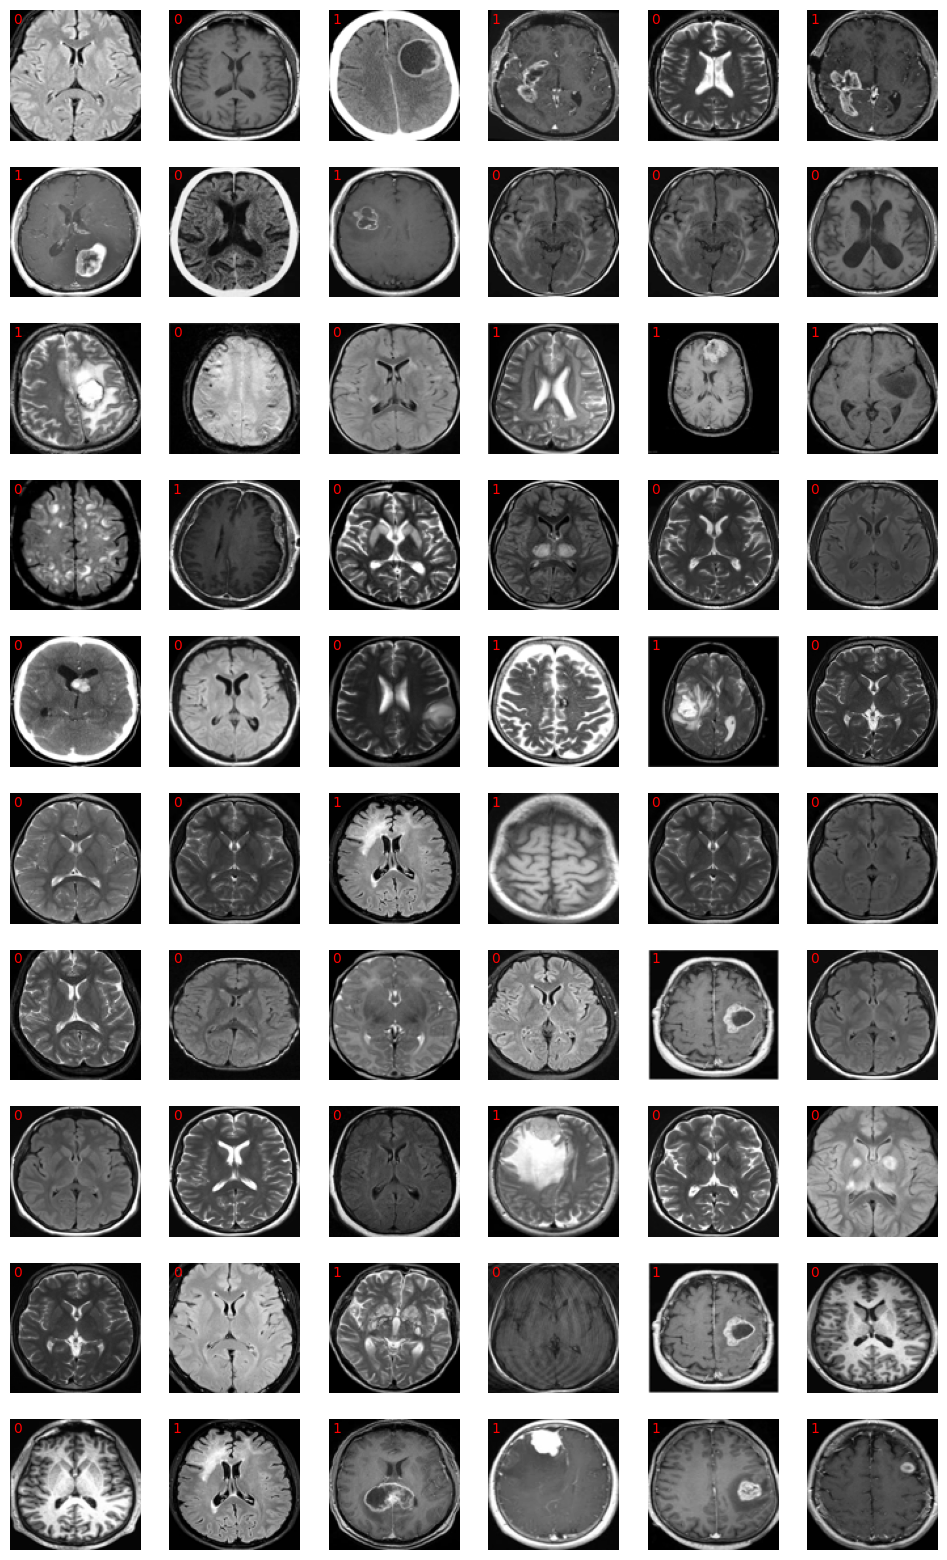

In [134]:
##
## Visualizing the prediction data with their SSIM labels
##
## SSIM does a good job of detecting obvious tumors but also has a number of apparent false positives
##
## However, this method is much less complex than a CNN though more computationally expensive
##

fig, ax = plt.subplots(10,6, figsize=(12,20))
for r in range(10):
    for c in range(6):
        i = r*6+c
        ax[r,c].imshow(pred[i], cmap='gray')
        ax[r,c].text(x=2,y=10, s=p_label[i,0].astype(int), color='red')
        ax[r,c].axis('off')
plt.show()

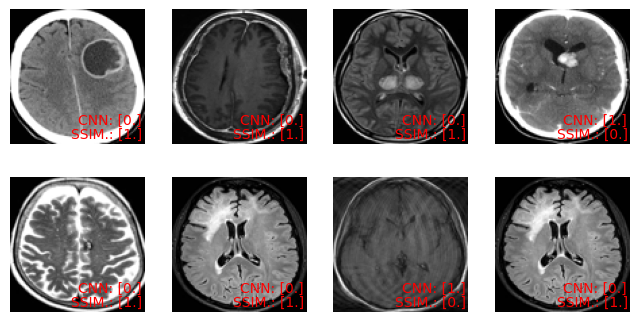

In [173]:
##
## Visualizing the different predictions between CNN and SSIM algorithms
##

same = p_label[:,0] != pred_labels[:,0]

fig, ax = plt.subplots(2,4, figsize=(8,4))
for r in range(2):
    for c in range(4):
        i = r*4+c
        
        ax[r,c].imshow(pred[same][i], cmap='gray')
        ax[r,c].axis('off')
        ax[r,c].text(x=50, y=85, s='CNN: {}'.format(pred_labels[np.argwhere(same)[i,0]]), color=(1,0,0))
        ax[r,c].text(x=45, y=95, s='SSIM.: {}'.format(p_label[np.argwhere(same)[i,0]]), color=(1,0,0))
        
plt.show()